# Bakas et al. data: 9 genes and 11 imaging features from gutman

In [1]:
%%capture
import pandas as pd
import numpy as np

# Append system path to look for additional modules (needed for rcca)
import sys
sys.path.append("/Users/kimrants/PycharmProjects/thesis_code/Thesis_code/Packages/")
sys.path.append("/Users/kimrants/PycharmProjects/thesis_code/Thesis_code/kim_code/")

# Import self-build script
import radiogenomics as r



# PCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA 
from sklearn.model_selection import KFold

#Plotly 
import plotly.plotly as py
from plotly.graph_objs import *
import plotly.tools as tls

import seaborn as sns
from scipy.stats.stats import pearsonr   
from sklearn.model_selection import train_test_split
import rcca
from scipy.spatial import distance_matrix

# Imports
import matplotlib.pyplot as plt
%matplotlib inline

path='/Users/kimrants/PycharmProjects/thesis_code/Thesis_code/Output_Data/Bakas57subjects/9genes_11img/'

In [2]:
from scipy import stats

a = [55, 27, -20, 5, 29]
b = [19, -25, 62, 76, 57]

a = [10,8,9,10,11]
b = [2,3,1,4,1]

stats.ttest_rel(a, b)


Ttest_relResult(statistic=8.488382153210786, pvalue=0.0010560879837902667)

# Data
### Gene data

In [3]:
# TCGA data
df_TCGA = r.download_data("TCGA") 
df_TCGA = r.make_clean_df("TCGA", df_TCGA) # (393, 17k)

# (TP53,  PTEN,  NF1,  EGFR,  IDH1,  PIK3R1,  RB1,  PIK3CA, and  PDGFRA) as Y-block
genes = ['TP53', 'PTEN', 'NF1', 'EGFR', 'IDH1','PIK3R1','RB1','PIK3CA','PDGFRA']
df_TCGA = df_TCGA[genes]   # (393,9)
df_TCGA.shape

(393, 9)

### Imaging Data (Bakas)

In [4]:
# Download and clean set up dataFrame:
df_TCIA = r.download_data("TCIA") 
df_TCIA = r.make_clean_df("TCIA", df_TCIA) # (102,704)
df_TCIA.shape

(102, 704)

In [5]:
%%capture
# VOLUME_ED = Volume_edema
# VOLUME_ET = Volume_enhanced
# VOLUME_NET = Volume_Necrosis

# Above is used to suppress warnings!
features = ['VOLUME_ED', 'VOLUME_ET', 'VOLUME_NET']
df_TCIA = df_TCIA[features]
df_TCIA.columns = ['ED', 'ET', 'NCR'] # Rename

# Add sums
df_TCIA['TC'] = df_TCIA['NCR'] + df_TCIA['ET']
df_TCIA['WT'] = df_TCIA['NCR'] + df_TCIA['ET'] + df_TCIA['ED']

# Add ratios
df_TCIA['NCR / ET'] = df_TCIA['NCR'] / df_TCIA['ET']
df_TCIA['ET / TC'] = df_TCIA['ET'] / df_TCIA['TC']
df_TCIA['ET / WT'] = df_TCIA['ET'] / df_TCIA['WT']
df_TCIA['NCR / WT'] = df_TCIA['NCR'] / df_TCIA['WT']
df_TCIA['ED / WT'] = df_TCIA['ED'] / df_TCIA['WT']
df_TCIA['TC / WT'] = df_TCIA['TC'] / df_TCIA['WT']

In [6]:
df_TCIA.shape

(102, 11)

### Only matches

In [7]:
# Apply AFTER correlation analysis
matches = r.find_matches(df_TCGA, df_TCIA)
df_TCIA = df_TCIA.loc[matches,:].astype(float) # (57,11); need to turn into float
df_TCGA = df_TCGA.loc[matches,:].astype(float) # (57,9)
df_TCGA.shape

(57, 9)

# Analysis
## Correlation of image features

Text(0.5,1,'Volume Correlations \n Sample:57')

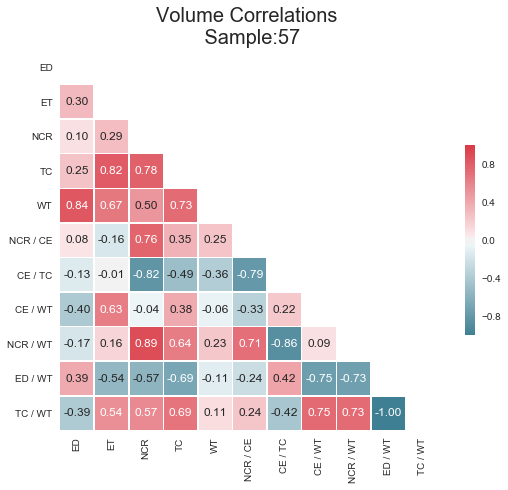

In [8]:
# Set style
sns.set(style="white")

# Compute the correlation matrix
corr = df_TCIA.corr() # TCIA = (102,11)
corr.index = ['ED', 'ET', 'NCR', 'TC', 'WT', 'NCR / CE', 'CE / TC', 'CE / WT', 'NCR / WT','ED / WT','TC / WT']
corr.columns = ['ED', 'ET', 'NCR', 'TC', 'WT', 'NCR / CE', 'CE / TC', 'CE / WT', 'NCR / WT','ED / WT','TC / WT']

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(9, 7))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0, fmt='.2f', annot = True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}).set_title("Volume Correlations \n Sample:" +str(df_TCIA.shape[0]), size=20)

Text(0.5,1,'Gene Correlations \n Sample:57')

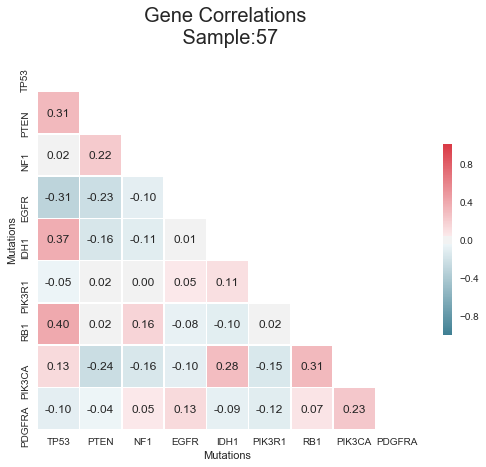

In [9]:
# Genes.
# Set style
sns.set(style="white")

# Compute the correlation matrix
corr = df_TCGA.corr() 
corr.index = df_TCGA.columns
corr.columns = df_TCGA.columns

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(9, 7))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1, vmin=-1, center=0, fmt='.2f', annot = True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}).set_title("Gene Correlations \n Sample:" +str(df_TCIA.shape[0]), size=20)


## Outliers
Only for imaging features. The gene data is sparse so makes no sense with distribution plot.

In [10]:
matches=57
# Make pivot
df_pivot_ed = pd.DataFrame(index=df_TCIA.index, columns=['Feature', 'Value'])
df_pivot_ed['Feature'] = ['ED' for i in range(matches)]
df_pivot_ed['Value'] = df_TCIA['ED']

df_pivot_en = pd.DataFrame(index=df_TCIA.index, columns=['Feature', 'Value'])
df_pivot_en['Feature'] = ['ET' for i in range(matches)]
df_pivot_en['Value'] = df_TCIA['ET']

df_pivot_ne = pd.DataFrame(index=df_TCIA.index, columns=['Feature', 'Value'])
df_pivot_ne['Feature'] = ['NCR' for i in range(matches)]
df_pivot_ne['Value'] = df_TCIA['NCR']

df_pivot_tb = pd.DataFrame(index=df_TCIA.index, columns=['Feature', 'Value'])
df_pivot_tb['Feature'] = ['TC' for i in range(matches)]
df_pivot_tb['Value'] = df_TCIA['TC']

df_pivot_vol = pd.DataFrame(index=df_TCIA.index, columns=['Feature', 'Value'])
df_pivot_vol['Feature'] = ['WT' for i in range(matches)]
df_pivot_vol['Value'] = df_TCIA['WT']

df_pivot_ne_ce = pd.DataFrame(index=df_TCIA.index, columns=['Feature', 'Value'])
df_pivot_ne_ce['Feature'] = ['NCR / ET' for i in range(matches)]
df_pivot_ne_ce['Value'] = df_TCIA['NCR / ET']

df_pivot_ce_tb = pd.DataFrame(index=df_TCIA.index, columns=['Feature', 'Value'])
df_pivot_ce_tb['Feature'] = ['ET / TC' for i in range(matches)]
df_pivot_ce_tb['Value'] = df_TCIA['ET / TC']

df_pivot_ce_vol = pd.DataFrame(index=df_TCIA.index, columns=['Feature', 'Value'])
df_pivot_ce_vol['Feature'] = ['ET / WT' for i in range(matches)]
df_pivot_ce_vol['Value'] = df_TCIA['ET / WT']

df_pivot_ne_vol = pd.DataFrame(index=df_TCIA.index, columns=['Feature', 'Value'])
df_pivot_ne_vol['Feature'] = ['NCR / WT' for i in range(matches)]
df_pivot_ne_vol['Value'] = df_TCIA['NCR / WT']

df_pivot_ed_vol = pd.DataFrame(index=df_TCIA.index, columns=['Feature', 'Value'])
df_pivot_ed_vol['Feature'] = ['ED / WT' for i in range(matches)]
df_pivot_ed_vol['Value'] = df_TCIA['ED / WT']

df_pivot_tb_vol = pd.DataFrame(index=df_TCIA.index, columns=['Feature', 'Value'])
df_pivot_tb_vol['Feature'] = ['TC / WT' for i in range(matches)]
df_pivot_tb_vol['Value'] = df_TCIA['TC / WT']


df_pivot = pd.concat([df_pivot_ed, 
                      df_pivot_en, 
                      df_pivot_ne, 
                      df_pivot_tb, 
                      df_pivot_vol, 
                      df_pivot_ne_ce, 
                      df_pivot_ce_tb, 
                      df_pivot_ce_vol,
                      df_pivot_ne_vol,
                      df_pivot_ed_vol,
                      df_pivot_tb_vol])
# Fix Feature Names
names = []
names.append(["ED" for i in range(matches*1)])
names.append(["ET" for i in range(matches*1)])
names.append(["NCR" for i in range(matches*1)])
names.append(["TC" for i in range(matches*1)])
names.append(["WT" for i in range(matches*1)])
names.append(["NCR/ET" for i in range(matches*1)])
names.append(["ET/TC" for i in range(matches*1)])
names.append(["ET/WT" for i in range(matches*1)])
names.append(["NCR/WT" for i in range(matches*1)])
names.append(["ED/WT" for i in range(matches*1)])
names.append(["TC/WT" for i in range(matches*1)])
names = [j for sub in names for j in sub] # Flatten
df_pivot['Feature']= names

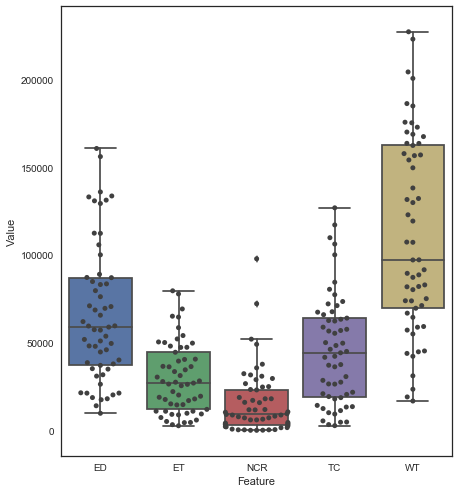

In [11]:
fig, ax = plt.subplots()
ax = sns.boxplot(x="Feature", y="Value", data=df_pivot.iloc[:matches*5,:])
ax = sns.swarmplot(x='Feature', y="Value", data=df_pivot.iloc[:matches*5,:], color=".25")
fig.set_size_inches(7, 8.27)

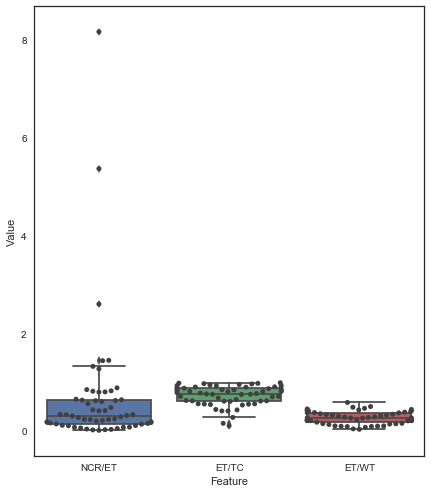

In [12]:
fig, ax = plt.subplots()
ax = sns.boxplot(x="Feature", y="Value", data=df_pivot.iloc[matches*5:matches*8,:])
ax = sns.swarmplot(x='Feature', y="Value", data=df_pivot.iloc[matches*5:matches*8,:], color=".25")
fig.set_size_inches(7, 8.27)

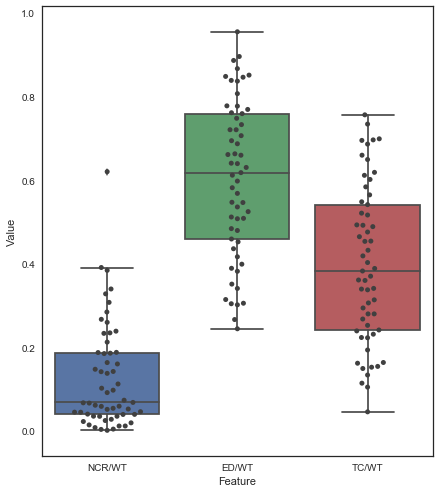

In [13]:
fig, ax = plt.subplots()
ax = sns.boxplot(x="Feature", y="Value", data=df_pivot.iloc[matches*8:,:])
ax = sns.swarmplot(x='Feature', y="Value", data=df_pivot.iloc[matches*8:,:], color=".25")
fig.set_size_inches(7, 8.27)

## CCA

# New version of rCCA where we get loadings / variates from R

In [14]:
# Split into test and training (img=X, genes=Y)
img_train, img_test, gene_train, gene_test = train_test_split(df_TCIA, # X
                                                    df_TCGA, # Y
                                                    test_size=0.2, 
                                                    random_state=42)     
print("img_train:", img_train.shape) 
print("img_test:", img_test.shape)
print("gene_train:", gene_train.shape)
print("gene_test:", gene_test.shape)

img_train: (45, 11)
img_test: (12, 11)
gene_train: (45, 9)
gene_test: (12, 9)


In [15]:
# Save data for R
img_train.to_csv(path + "img_for_R_tuning")
gene_train.to_csv(path + "gene_for_R_tuning")

In [16]:
# Load data from R - loadings
df_load_genes = pd.read_csv(path + 'R_loadings_genes')
df_load_genes = df_load_genes.set_index('Unnamed: 0', drop=True)
df_load_genes.index.name ='gene'
print(df_load_genes.shape)

df_load_img = pd.read_csv(path + 'R_loadings_img')
df_load_img = df_load_img.set_index('Unnamed: 0', drop=True)
df_load_img.index.name ='PC'
print(df_load_img.shape)

(9, 5)
(11, 5)


In [17]:
# Compute test variates
rep_var_TCIA = np.matmul(img_test.values, df_load_img.values) # Values * weights
rep_var_TCIA = StandardScaler().fit_transform(rep_var_TCIA) # Need to standardise 

# Create variates TCGA
rep_var_TCGA = np.matmul(gene_test.values, df_load_genes.values)
rep_var_TCGA = StandardScaler().fit_transform(rep_var_TCGA) # Need to standardise 

# DataFrames
df_rep_var_TCIA = pd.DataFrame(data=rep_var_TCIA)
df_rep_var_TCGA = pd.DataFrame(data=rep_var_TCGA)

In [18]:
# Correlation 
test_corr = [np.corrcoef(df_rep_var_TCIA.iloc[:,0], df_rep_var_TCGA.iloc[:,0])[0][1],
             np.corrcoef(df_rep_var_TCIA.iloc[:,1], df_rep_var_TCGA.iloc[:,1])[0][1],
             np.corrcoef(df_rep_var_TCIA.iloc[:,2], df_rep_var_TCGA.iloc[:,2])[0][1],
             np.corrcoef(df_rep_var_TCIA.iloc[:,3], df_rep_var_TCGA.iloc[:,3])[0][1],
             np.corrcoef(df_rep_var_TCIA.iloc[:,4], df_rep_var_TCGA.iloc[:,4])[0][1]]
test_corr

[0.026091881897645764,
 0.5480271884281672,
 0.29772591062473813,
 -0.3117886358949192,
 -0.4387031223058272]

In [19]:
# Plot just histogram
data_scree = r.plotly_scree_CCA(test_corr)

# Plot layout
layout=Layout(
        yaxis=dict(
            YAxis(title='Canonical Correlation'),
            range=[-0.5,1]
        ),
        title='Canonical Correlation Analysis')

fig_scre = Figure(data=data_scree, layout=layout)
py.iplot(fig_scre)

### Look inside first canonical pair for genes and imaging respectively (img first, then genes)
I have not made it relative weights! i.e. I have not said w_i / w_sum

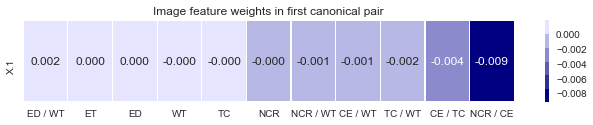

In [20]:
# set GLOBAL decimal precision
pd.set_option('display.float_format', lambda x: '%.4f' % x)

indeces = ['ED', 'ET', 'NCR', 'TC', 'WT', 'NCR / CE', 'CE / TC', 'CE / WT', 'NCR / WT','ED / WT','TC / WT']

# Sort
df_load_img.index = indeces
df_load_img = df_load_img.sort_values(by=['X.1'], ascending=False) 
df = df_load_img.drop(['X.2', 'X.3', 'X.4', 'X.5'], axis=1)
df.columns.name = ''

# Plot- Construct cmap
my_cmap = sns.light_palette("navy", reverse=True)

# Plot
plt.figure(figsize=(11,1.5))
plt.title('Image feature weights in first canonical pair')
sns.heatmap(df.T, cmap=my_cmap, annot=True, fmt='.3f', linewidths=0.1)

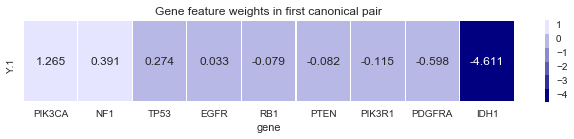

In [21]:
# Sort
df_load_genes = df_load_genes.sort_values(by=['Y.1'], ascending=False) 
df = df_load_genes.drop(['Y.2', 'Y.3', 'Y.4', 'Y.5'], axis=1)
df.columns.name = ''

# Plot- Construct cmap
my_cmap = sns.light_palette("navy", reverse=True)

# Plot
plt.figure(figsize=(11,1.5))
plt.title('Gene feature weights in first canonical pair')
sns.heatmap(df.T, cmap=my_cmap, annot=True, fmt='.3f', linewidths=0.1)

# Test robustness of estimate and variance in optimal reg. parameters
### New "test" of test set
Doesn't matter that there is overlap to the other... we don't estimate model performance from this, just to see the amount of variance

In [22]:
d={}
kf = KFold(n_splits=5, random_state=False, shuffle=False)

i = 1
for tr_ind, tst_ind in kf.split(df_TCIA):
    img_train, img_test = df_TCIA.iloc[tr_ind,], df_TCIA.iloc[tst_ind]
    gene_train, gene_test = df_TCGA.iloc[tr_ind], df_TCGA.iloc[tst_ind]
    # Save data for R
    img_train.to_csv(path + "img_for_R_tuning_"+str(i))
    gene_train.to_csv(path + "gene_for_R_tuning_"+str(i))
    d['img_test_'+str(i)] = img_test
    d['genes_test_'+str(i)] = gene_test
    i += 1

In [23]:
# Load data from R - loadings
for i in range(1,6):
    df_lambd1 = pd.read_csv(path + 'R_optLambda1_' + str(i))
    d['lamda1_'+str(i)] = df_lambd1.loc[0,'x']
    
    df_lambd2 = pd.read_csv(path + 'R_optLambda2_' + str(i))
    d['lamda2_'+str(i)] = df_lambd2.loc[0,'x']
    
    df_load_genes = pd.read_csv(path + 'R_loadings_genes_'+str(i))
    df_load_genes = df_load_genes.set_index('Unnamed: 0', drop=True)
    df_load_genes.index.name ='gene'
    d['df_genes_'+str(i)] = df_load_genes
    print(d['df_genes_'+str(i)].shape)
    
    df_load_img = pd.read_csv(path + 'R_loadings_img_'+str(i))
    df_load_img = df_load_img.set_index('Unnamed: 0', drop=True)
    df_load_img.index.name ='PC'
    d['df_img_'+str(i)] = df_load_img

    # Compute test variates
    rep_var_TCIA = np.matmul(d['img_test_'+str(i)].values, d['df_img_'+str(i)].values) # Values * weights
    rep_var_TCIA = StandardScaler().fit_transform(rep_var_TCIA) # Need to standardise 

    # Create variates TCGA
    rep_var_TCGA = np.matmul(d['genes_test_'+str(i)].values, d['df_genes_'+str(i)].values)
    rep_var_TCGA = StandardScaler().fit_transform(rep_var_TCGA) # Need to standardise 

    # DataFrames
    df_rep_var_TCIA = pd.DataFrame(data=rep_var_TCIA)
    df_rep_var_TCGA = pd.DataFrame(data=rep_var_TCGA)
    
    # Correlation 
    test_corr = [np.corrcoef(df_rep_var_TCIA.iloc[:,0], df_rep_var_TCGA.iloc[:,0])[0][1],
             np.corrcoef(df_rep_var_TCIA.iloc[:,1], df_rep_var_TCGA.iloc[:,1])[0][1],
             np.corrcoef(df_rep_var_TCIA.iloc[:,2], df_rep_var_TCGA.iloc[:,2])[0][1],
             np.corrcoef(df_rep_var_TCIA.iloc[:,3], df_rep_var_TCGA.iloc[:,3])[0][1],
             np.corrcoef(df_rep_var_TCIA.iloc[:,4], df_rep_var_TCGA.iloc[:,4])[0][1]]
    d['test_corr_'+str(i)] = test_corr
    
    df_cv = pd.read_csv(path + 'R_rCCA_CV_'+str(i))
    df_cv.drop('Unnamed: 0', inplace=True, axis=1)
    d['max_cv_'+str(i)] = df_cv.max().max().round(4)

(9, 5)
(9, 5)
(9, 5)
(9, 5)
(9, 5)


In [24]:
# set GLOBAL decimal precision
pd.set_option('display.float_format', lambda x: '%.7f' % x)
indeces = [i for i in range(1,6)]
columns = ['test_corr_cc1', 'CV-score','Reg1','Reg2']

# Make data
data = []
for i in range(1,6):
    inner = []
    inner.append(d['test_corr_'+str(i)][0])
    inner.append(d['max_cv_'+str(i)])
    inner.append(d['lamda1_'+str(i)])
    inner.append(d['lamda2_'+str(i)])
    data.append(inner)

# Make DF
df_overview = pd.DataFrame(data=data, index=indeces, columns=columns)
df_overview # Engineer this shit.. 

test_corr_cc1  CV-score      Reg1      Reg2
1      0.3108894 0.3405000 5.0000000 5.0000000
2      0.7453114 0.1870000 1.8421059 0.0000010
3      0.0904801 0.4510000 0.0000010 5.0000000
4      0.4123837 0.3567000 5.0000000 0.2631588
5     -0.4914842 0.3637000 0.0000010 0.0000010

# CV HEATMAP
Problem: I really shouldn't need to use regularisation here, but I do?<br>
Don't understand why high regularisation is optimal?

In [25]:
# Load 
df_cv = pd.read_csv(path +'R_rCCA_CV')
grid = pd.read_csv(path + 'R_rCCA_grid')

# Get index list, round to 4 decimals
index_list = list(grid['x'])
index_list = [ '%.4f' % elem for elem in index_list ]

# Drop current "index"
df_cv.drop('Unnamed: 0', inplace=True, axis=1)

# set rows and columns (symmetric)
df_cv.index = index_list
df_cv.columns = index_list

# Find max and related index/columns
max_score = df_cv.iloc[0,0]
index = list(df_cv.index)[0]
col = list(df_cv.columns)[0]

for index_row, row in df_cv.iterrows():
    for index_column, dist in row.iteritems():
        if df_cv.loc[index_row,index_column] > max_score:
            max_score = df_cv.loc[index_row,index_column]
            index = index_row
            col = index_column
print("Max_socre is: ", max_score)
print(df_cv.max().max().round(4))

Max_socre is:  0.554089918603416
0.5541


[Text(29.5,0.5,'Lambda1'), Text(0.5,11.5,'Lambda2')]

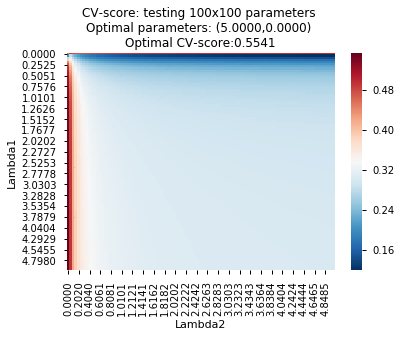

In [8]:
# MAKE SURE THAT INDEX/COL is CORRECT WITH LAMBDA1 / LAMBDA2
fig = sns.heatmap(df_cv, cmap="RdBu_r")
fig.set_title("CV-score: testing " + str(len(index_list))+"x" + str(len(index_list)) + " parameters \n" + 
             "Optimal parameters: (" +  index + "," + col +") \n" +
             "Optimal CV-score:" + str(max_score.round(4)))
fig.set(xlabel='Lambda2', ylabel='Lambda1')

## t-SNE (57 subjects) 
### Generate data for Dash

In [8]:
# Add additional columns
# Get df of gene groups (number represents mutations)
df_gene_groups = r.df_gene_groups()
df_gene_groups = df_gene_groups.filter(list(df_TCIA.index), axis='index')

# Get gene data and prim vs. secondary + groupings to send more complete data to dash
df_TCGA = df_TCGA.filter(list(df_TCIA.index), axis='index')
df_prim_sec = r.get_prim_sec_from_idh1(df_TCGA)

# combine first
df_to_add = r.add_info(df_gene_groups, df_prim_sec.T.values.tolist(), df_prim_sec.columns)

# combine second
df_TCGA_FINAL = r.add_info(df_to_add, df_TCGA.T.values.tolist(), df_TCGA.columns)
df_TCGA_FINAL.shape

(57, 34)

In [9]:
run = False
if run:
    r.Dash_tsne_no_PCA(df_TCIA, df_to_add, path)        

### t-SNE association algorithm
Neighbours only. Ignore threshold to start

In [10]:
# For dataFrame
columns = ['Score', 
           't-SNE dimensions', 
           'Principal Components', 
           'Perplexity', 
           'Learning Rate', 
           'k', 
           'Threshold', 
           'Corrects', 
           'Total']

### Best result with k=5 + No_threshold

In [ ]:
# Get Results
k=5
run=False  
if run:
    dict_opt_param, data = r.tsne_optimal_hyperparameters(ks=[k], 
                                                                         thresholds=[99999], 
                                                                         tsne_dims= r.tsne_dims, 
                                                                         PCs=['NO'], 
                                                                         perps=r.perps, 
                                                                         learn_rates=r.learn_rates,
                                                                         subjects=list(df_TCGA_FINAL.index),
                                                                         path=path)
    np.save(path+"dict_opt_param_k="+str(k)+"_thres=NO"+"_allVariations", dict_opt_param)
    df = pd.DataFrame(data=data, columns=columns) 
    df.to_csv(path + "data_opt_param_k="+str(k)+"_thres=NO"+"_allVariations")
else: 
    dict_opt_param = np.load(path +"dict_opt_param_k="+str(k)+"_thres=NO"+"_allVariations"+".npy").item()
    df = pd.read_csv(path+"data_opt_param_k="+str(k)+"_thres=NO"+"_allVariations")
    df = df.set_index('Unnamed: 0')
                

# Print info
print('\n\n')             
print("best score is", dict_opt_param['score'])
print("Possible correct: ", dict_opt_param['total'])
print("Correct: ", dict_opt_param['corrects'])
print("Dim: ", dict_opt_param['dim'])
print("PC: ", dict_opt_param['pc'])
print("Perp: ", dict_opt_param['perp'])
print("LearnRate: ", dict_opt_param['learnRate'])
print("k: ", dict_opt_param['k'])
print("Thres: ", dict_opt_param['thres'])

### Best result for different Ks, No Threshold. 

In [ ]:
# Get Results
k=[1,2,3,4,5,6,7,9,10,12,15,18,20,25,29,35,45,52,56]
run=False
if run:
    dict_opt_param, data = r.tsne_optimal_hyperparameters(ks=k, 
                                                                         thresholds=[99999], 
                                                                         tsne_dims= r.tsne_dims, 
                                                                         PCs=['NO'], 
                                                                         perps=r.perps, 
                                                                         learn_rates=r.learn_rates,
                                                                         subjects=list(df_TCGA_FINAL.index),
                                                                         path=path)
    np.save(path+"dict_opt_param_k="+str(k)+"_thres=NO", dict_opt_param)
    df = pd.DataFrame(data=data, columns=columns) 
    df.to_csv(path + "data_opt_param_k="+str(k)+"_thres=NO")
else: 
    dict_opt_param = np.load(path +"dict_opt_param_k="+str(k)+"_thres=NO"+".npy").item()
    df = pd.read_csv(path+"data_opt_param_k="+str(k)+"_thres=NO")
    df = df.set_index('Unnamed: 0')
                

# Print info
print('\n\n')             
print("best score is", dict_opt_param['score'])
print("Possible correct: ", dict_opt_param['total'])
print("Correct: ", dict_opt_param['corrects'])
print("Dim: ", dict_opt_param['dim'])
print("PC: ", dict_opt_param['pc'])
print("Perp: ", dict_opt_param['perp'])
print("LearnRate: ", dict_opt_param['learnRate'])
print("k: ", dict_opt_param['k'])
print("Thres: ", dict_opt_param['thres'])

### Best result, k=5, different thresholds
thres >=2 always.

In [ ]:
# Get Results
k=5
thres = [2, 3,4,5,7,10,12,15,20,25,30,50,100]
run=False
if run:
    dict_opt_param, data = r.tsne_optimal_hyperparameters(ks=[k], 
                                                                         thresholds=thres, 
                                                                         tsne_dims= r.tsne_dims, 
                                                                         PCs=['NO'], 
                                                                         perps=r.perps, 
                                                                         learn_rates=r.learn_rates,
                                                                         subjects=list(df_TCGA_FINAL.index),
                                                                         path=path)
    
    np.save(path+"dict_opt_param_k="+str(k)+"_thres="+str(thres), dict_opt_param)
    df = pd.DataFrame(data=data, columns=columns) 
    df.to_csv(path + "data_opt_param_k="+str(k)+"_thres="+str(thres))
else: 
    dict_opt_param = np.load(path +"dict_opt_param_k="+str(k)+"_thres="+str(thres)+".npy").item()
    df = pd.read_csv(path+"data_opt_param_k="+str(k)+"_thres="+str(thres))
    df = df.set_index('Unnamed: 0')
                

# Print info
print('\n\n')             
print("best score is", dict_opt_param['score'])
print("Possible correct: ", dict_opt_param['total'])
print("Correct: ", dict_opt_param['corrects'])
print("Dim: ", dict_opt_param['dim'])
print("PC: ", dict_opt_param['pc'])
print("Perp: ", dict_opt_param['perp'])
print("LearnRate: ", dict_opt_param['learnRate'])
print("k: ", dict_opt_param['k'])
print("Thres: ", dict_opt_param['thres'])

### Best result, k=5, No Threshold, Dim = 2

In [ ]:
# Get Results
k=5
run=False 
if run:
    dict_opt_param, data = r.tsne_optimal_hyperparameters(ks=[k], 
                                                                         thresholds=[99999], 
                                                                         tsne_dims= [2], 
                                                                         PCs=['NO'], 
                                                                         perps=r.perps, 
                                                                         learn_rates=r.learn_rates,
                                                                         subjects=list(df_TCGA_FINAL.index),
                                                                         path=path)
    np.save(path+"dict_opt_param_k="+str(k)+"_thres=NO"+"_dim=2", dict_opt_param)
    df = pd.DataFrame(data=data, columns=columns) 
    df.to_csv(path + "data_opt_param_k="+str(k)+"_thres=NO"+"_dim=2")
else: 
    dict_opt_param = np.load(path +"dict_opt_param_k="+str(k)+"_thres=NO"+"_dim=2"+".npy").item()
    df = pd.read_csv(path+"data_opt_param_k="+str(k)+"_thres=NO"+"_dim=2")
    df = df.set_index('Unnamed: 0')
                

# Print info
print('\n\n')             
print("best score is", dict_opt_param['score'])
print("Possible correct: ", dict_opt_param['total'])
print("Correct: ", dict_opt_param['corrects'])
print("Dim: ", dict_opt_param['dim'])
print("PC: ", dict_opt_param['pc'])
print("Perp: ", dict_opt_param['perp'])
print("LearnRate: ", dict_opt_param['learnRate'])
print("k: ", dict_opt_param['k'])
print("Thres: ", dict_opt_param['thres'])

# One complete run

In [11]:
# Get Results
k=[2,5,8,10]
thres = [2,3,4,5,10,20,100]
run=False   
if run:
    dict_opt_param, data = r.tsne_optimal_hyperparameters(ks=k, 
                                                                         thresholds=thres, 
                                                                         tsne_dims= r.tsne_dims, 
                                                                         PCs=['NO'], 
                                                                         perps=r.perps, 
                                                                         learn_rates=r.learn_rates,
                                                                         subjects=list(df_TCGA_FINAL.index),
                                                                         path=path)
    
    np.save(path+"DICT_OPT_PARAM", dict_opt_param)
    df = pd.DataFrame(data=data, columns=columns) 
    df.to_csv(path + "T-SNE_DF_DATA")
else: 
    dict_opt_param = np.load(path +"DICT_OPT_PARAM"+".npy").item()
    df = pd.read_csv(path+"T-SNE_DF_DATA")
    df = df.set_index('Unnamed: 0')
                

# Print info
print('\n\n')             
print("best score is", dict_opt_param['score'])
print("Possible correct: ", dict_opt_param['total'])
print("Correct: ", dict_opt_param['corrects'])
print("Dim: ", dict_opt_param['dim'])
print("PC: ", dict_opt_param['pc'])
print("Perp: ", dict_opt_param['perp'])
print("LearnRate: ", dict_opt_param['learnRate'])
print("k: ", dict_opt_param['k'])
print("Thres: ", dict_opt_param['thres'])




best score is 0.625
Possible correct:  8
Correct:  3
Dim:  3
PC:  NO
Perp:  10
LearnRate:  200
k:  2
Thres:  2


### Neighbour matrix

In [23]:
k=[2,5,8,10]
thres = [2,3,4,5,10,20,100]
k_thres_neighbours = {}
for this_k in k:
    for this_thres in thres:
        # Download genomic distance matrix from Paul (all genes)
        dist_matrix_gene = pd.read_csv(r.dist_matrix_path)
        dist_matrix_gene.set_index('Unnamed: 0', inplace=True, drop=True)

        dist_matrix_gene = dist_matrix_gene[matches]
        dist_matrix_gene = dist_matrix_gene.T[matches]

        # Identify k closests neighbours for each data point in Genomic Space; this is ground truth
        k_closest_genomic = r.k_closest(dist_matrix_gene, this_k)
        # Apply Threshold
        thres_k_closest_genomic = r.apply_threshold_on_k_closest(k_closest_genomic, dist_matrix_gene,
                                                                                   this_thres)
        
        k_thres_neighbours['k='+str(this_k)+'_thres='+str(this_thres)] = thres_k_closest_genomic

In [29]:
np.save(path + 'k_thres_neighbours', k_thres_neighbours)

# Plots
### Cost plot: fixed k, no threshold, no PCA, dim=2 varying learning rate and perplexity, 

In [ ]:
# Get Results
k=5
dict_opt_param = np.load(path +"dict_opt_param_k="+str(k)+"_thres=NO"+"_dim=2"+".npy").item()
df = pd.read_csv(path+"data_opt_param_k="+str(k)+"_thres=NO"+"_dim=2")
df = df.set_index('Unnamed: 0')
                

# Print info
print('\n\n')             
print("best score is", dict_opt_param['score'])
print("Possible correct: ", dict_opt_param['total'])
print("Correct: ", dict_opt_param['corrects'])
print("Dim: ", dict_opt_param['dim'])
print("PC: ", dict_opt_param['pc'])
print("Perp: ", dict_opt_param['perp'])
print("LearnRate: ", dict_opt_param['learnRate'])
print("k: ", dict_opt_param['k'])
print("Thres: ", dict_opt_param['thres'])

In [ ]:
# Pick out data for axes
x = r.perps
y = r.learn_rates
X, Y = np.meshgrid(x, y)

# Can only plot two dimensions: Fix the other dimensions at optimal
# Fix PC and t-SNE dimensions at optimum, then have perp / learnRate on axes
df = df.loc[df['t-SNE dimensions'] == dict_opt_param['dim']] 
df = df.loc[df['Principal Components'] == str(dict_opt_param['pc'])]
pivot = pd.pivot_table(data=df, 
                       values='Score', 
                       index='Perplexity', 
                       columns='Learning Rate')

# Create Data
data = [
    Surface(
        z=pivot.T.values,
        x=X,
        y=Y
    )
]

# Beautify layout
layout = Layout(
    title='Surface Plot of Error for k=' + str(k) + "<br>" 
    + "NB: Can only show 2 dimensions, so PCs/t-SNE fixed." ,
    autosize=False,
    width=800,
    height=600,
    scene = dict(xaxis = dict(title='Perplexity'),
                yaxis = dict(title='Learning Rate'),
                zaxis = dict(title='Error'),
                ),
    margin=dict(
        l=65,
        r=50,
        b=65,
        t=90
    )    
)

# Plot
fig = Figure(data=data, layout=layout)
py.iplot(fig, filename='3d-surface')

### k Plot (no thres, no PCA, dim=opt, learnRate=opt, Perp=opt)

In [ ]:
# Get Results
k=[1,2,3,4,5,6,7,9,10,12,15,18,20,25,29,35,45,52]
dict_opt_param = np.load(path +"dict_opt_param_k="+str(k)+"_thres=NO"+".npy").item()
df = pd.read_csv(path+"data_opt_param_k="+str(k)+"_thres=NO")
df = df.set_index('Unnamed: 0')
                

# Print info
print('\n\n')             
print("best score is", dict_opt_param['score'])
print("Possible correct: ", dict_opt_param['total'])
print("Correct: ", dict_opt_param['corrects'])
print("Dim: ", dict_opt_param['dim'])
print("PC: ", dict_opt_param['pc'])
print("Perp: ", dict_opt_param['perp'])
print("LearnRate: ", dict_opt_param['learnRate'])
print("k: ", dict_opt_param['k'])
print("Thres: ", dict_opt_param['thres'])

In [ ]:
list_score = []
for k_val in k:
    df_segment = df.loc[df['k'] == k_val] # get only rows with specific k-value
    df_segment['col'] = [i for i in range(160)] # Re-set index to start from 0
    df_segment = df_segment.set_index('col', drop=True) # Make the column the index
    row = df_segment.iloc[df_segment['Score'].idxmin()] # Select max row
    list_score.append(row['Score']) # append value

X = k
Y = list_score
# Create a trace
trace = Scatter(
    x = X,
    y = Y,
)

layout = dict(title = 'Best performing hyperparameters for different k',
              yaxis = dict(title='Error'),
              xaxis = dict(title='k')
             )

# Plot
data = [trace]
fig = dict(data=data, layout=layout)
py.iplot(fig, filename='basic-line')


### Threshold plot (k=5, no PCA, dim=opt, learnRate=opt, Perp=opt)

In [ ]:
# Get Results
k=5
thres = [2, 3,4,5,7,10,12,15,20,25,30,50,100]
dict_opt_param = np.load(path +"dict_opt_param_k="+str(k)+"_thres="+str(thres)+".npy").item()
df = pd.read_csv(path+"data_opt_param_k="+str(k)+"_thres="+str(thres))
df = df.set_index('Unnamed: 0')
                

# Print info
print('\n\n')             
print("best score is", dict_opt_param['score'])
print("Possible correct: ", dict_opt_param['total'])
print("Correct: ", dict_opt_param['corrects'])
print("Dim: ", dict_opt_param['dim'])
print("PC: ", dict_opt_param['pc'])
print("Perp: ", dict_opt_param['perp'])
print("LearnRate: ", dict_opt_param['learnRate'])
print("k: ", dict_opt_param['k'])
print("Thres: ", dict_opt_param['thres'])

In [ ]:
list_score = []
for thres_val in thres:
    df_segment = df.loc[df['Threshold'] == thres_val] # get only rows with specific k-value
    df_segment['col'] = [i for i in range(160)] # Re-set index to start from 0
    df_segment = df_segment.set_index('col', drop=True) # Make the column the index
    row = df_segment.iloc[df_segment['Score'].idxmin()] # Select max row
    list_score.append(row['Score']) # append value

X = thres
Y = list_score
# Create a trace
trace = Scatter(
    x = X,
    y = Y,
)

layout = dict(title = 'Best performing hyperparameters for different thresholds',
              yaxis = dict(title='Error'),
              xaxis = dict(title='Threshold')
             )

# Plot
data = [trace]
fig = dict(data=data, layout=layout)
py.iplot(fig, filename='basic-line')
